#STOCK PRICE PREDICTION

**Introduction**

In this work we are going to be building a model that predicts stock prices through a neural network.

First thing first, **What is a time series?**
A time series problem deals with data over time, in our case, predicting a stock price for the next 10 days requires the analysis of the prior data.
According on which kind of task are we dealing with, we can talk about **Classification**, if the output is a discrete value (a category) or **Forecasting** if it's a continuous value.
We are in the latter case, since we are trying to predict a specific price, the stock price indeed.
It's fascinating to notice that our task can be easily converted in a Classification problem if we are more interested in predicting the trend rather than the exact value since the Neural Network, because of intrinsic nature, is not perfect for this kind of problem.

## Get data and data preprocessing
In order to build the model we need a csv file that provides the trend of our stock over the past years, we are going to use yahoo finance for that [Yahoo Finance](https://finance.yahoo.com/quote/PFE/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAJY7AM03mGkaja5jdFK4KOfe4mVe5olYTAT1voR-eMKSB3m1USujbCt5shhTsrKC_iD416ihvSi-RvFYPGUKbJUDObZ89eEaugNF8UvQUEqDcRCJMZYXfJ9Lt3uegzfABrS6c1vjyOpHbGDbGagOvBpZNoieuCLkNU40ZgmyFraD).
The stock we choce to predict is PFE (Pfizer), the reasons for this choice are: 

1.   **Long historical data**: as we know, one of the Deep Learning motto is: "the more data, the better". Compared to other companies PFE is pretty old, that is translated in a very long dataset.
2.   **Personal idea**: In my personal opinion, PFE's price will increase in the next years thanks to the huge contribute the company gave to contain the pandemic. 

The dataset can be found here: [download](https://query1.finance.yahoo.com/v7/finance/download/PFE?period1=76291200&period2=1638057600&interval=1d&events=history&includeAdjustedClose=true)

**Installing dependencies**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime

**Importing the dataset**

**Add PFE.csv into sample_data**

In [ ]:
#Importing the csv file ...
data = pd.read_csv("/content/sample_data/PFE.csv")

In [ ]:
data = data.rename(columns = {'Date': 'timestamp', 
                              'High': 'high', 
                              'Low': 'low', 
                              'Open': 'open', 
                              'Close': 'close', 
                              'Volume': 'volume'}, inplace = False)
true = data.tail(10)
#data = data.drop(data.tail(3).index,axis=0)
data

,timestamp,open,high,low,close,Adj Close,volume
0,1972-06-02,0.815346,0.817817,0.802993,0.805463,0.180096,1613885
1,1972-06-05,0.805463,0.807934,0.798051,0.802993,0.179544,2585251
2,1972-06-06,0.802993,0.825229,0.800522,0.820288,0.183411,2347469
3,1972-06-07,0.820288,0.820288,0.807934,0.820288,0.183411,1032077
4,1972-06-08,0.820288,0.822759,0.815346,0.815346,0.182306,1067491
...,...,...,...,...,...,...,...
12476,2021-11-19,51.959999,52.840000,50.680000,50.799999,50.799999,47966200
12477,2021-11-22,50.950001,51.470001,50.380001,51.200001,51.200001,27287900
12478,2021-11-23,50.580002,51.450001,50.299999,51.080002,51.080002,24946200
12479,2021-11-24,51.180000,51.330002,50.709999,50.889999,50.889999,18556800


In [ ]:
#true will be the list we are goint to predict: Target values
true

,timestamp,open,high,low,close,Adj Close,volume
12471,2021-11-12,50.419998,50.490002,49.570000,49.730000,49.730000,27766700
12472,2021-11-15,49.730000,50.099998,49.369999,49.650002,49.650002,27763200
12473,2021-11-16,49.470001,50.160000,48.889999,49.599998,49.599998,31297200
12474,2021-11-17,49.939999,51.090000,49.689999,50.869999,50.869999,36889800
12475,2021-11-18,51.099998,51.709999,50.610001,51.410000,51.410000,32872600
12476,2021-11-19,51.959999,52.840000,50.680000,50.799999,50.799999,47966200
12477,2021-11-22,50.950001,51.470001,50.380001,51.200001,51.200001,27287900
12478,2021-11-23,50.580002,51.450001,50.299999,51.080002,51.080002,24946200
12479,2021-11-24,51.180000,51.330002,50.709999,50.889999,50.889999,18556800
12480,2021-11-26,54.040001,54.939999,53.250000,54.000000,54.000000,66561300


After we renamend the data columns and dropped the last 10 rows from the columns and stored them in a different list called **true**, we are ready to preprocess the dataset.

**Checking if GPU is connected**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-3294d8f3-3b93-461b-060e-362c50ac9beb)


Since we are gonna be using more than a column in order to predict the Close values, we are dealing with a **multivariate time series**.
These values columns are filled with some statistical indicators that are going to be chose thanks to a correlation matrix.

**TA-Lib** is widely used by trading software developers requiring to perform technical analysis of financial market data. [TA-lib reference](https://mrjbq7.github.io/ta-lib/)

In [ ]:
#Importing talib which will be used to compute some indicators

url = "https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files"
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib as ta

Selecting previously unselected package libta-lib0.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 268 kB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.22-cp37-cp37m-linux_x86_64.whl size=1465690 sha256=fed6d76137c8f2dd86f9a7f01816d6ac22692a0312f10e3faffe9a19e527c11a
  Stored in direc

By doing some researches we noticed that the most used statistical used for trading stocks are:
OBV, CCI, TRIX, RSI, ADX, ROC, MOM, EMA, ATR, TRENDMODE, TRENDLINE and VWAP.
The latter cannot be found in ta-lib, so I decided to implement it from scratches.

**Finally I added each and every indicators as a column of the previous Dataset.**

In [ ]:
#OBV
data["OBV"] = ta.OBV(data.close,data.volume)

#CCI
data["CCI"] = ta.CCI(np.asarray(data["high"]),
                              np.asarray(data["low"]),
                              np.asarray(data["close"]),
                              timeperiod=26)
#TRIX
data["TRIX"] = ta.TRIX(np.asarray(data["close"]), timeperiod=26)

#MACD
#data["MACD"] = ta.MACD(np.asarray(data["close"]), fastperiod=12, slowperiod=26, signalperiod=9)

#RSI
data["RSI"] = ta.RSI(np.asarray(data["close"]), timeperiod=26)

#ADX
data["ADX"] = ta.ADX(np.asarray(data["high"]),
                     np.asarray(data["low"]),
                     np.asarray(data["close"]),
                     timeperiod=26)

#ROC
data["ROC"] = ta.ROC(np.asarray(data["close"]), timeperiod=26)

#MOMENTUM
data["MOM"] = ta.MOM(np.asarray(data["close"]), timeperiod=26)

#EMA
data["EMA"] = ta.EMA(data.close,26)

#VWAP

def getVWAP():
  tipicalPrice = []
  for value in np.asarray(data):
    high = value[1]
    low = value[2]
    close = value[3]
    tp = ((high+low+close)/3)
    tipicalPrice.append(tp)
  sum = 0

  for i in range(len(tipicalPrice)):
    sum = sum + tipicalPrice * np.asarray(data)[:,4]
  cumulativeVolume = 0

  for value in np.asarray(data):
    cumulativeVolume = cumulativeVolume + np.asarray(data)[:,4]
    vwap = sum/cumulativeVolume
  return vwap

#data["vwap"] = getVWAP()

#ATR
data["ATR"] = ta.ATR(np.asarray(data["high"]), np.asarray(data["low"]), 
                     np.asarray(data["close"]), timeperiod=14)

#TRENDMODE
data["TrendMode"] = ta.HT_TRENDMODE(np.asarray(data["close"]))

#TRENDLINE
data["TrendLine"] = ta.HT_TRENDLINE(np.asarray(data["close"]))

data


,timestamp,open,high,low,close,Adj Close,volume,OBV,CCI,TRIX,RSI,ADX,ROC,MOM,EMA,ATR,TrendMode,TrendLine
0,1972-06-02,0.815346,0.817817,0.802993,0.805463,0.180096,1613885,1.613885e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,1972-06-05,0.805463,0.807934,0.798051,0.802993,0.179544,2585251,-9.713660e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,1972-06-06,0.802993,0.825229,0.800522,0.820288,0.183411,2347469,1.376103e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,1972-06-07,0.820288,0.820288,0.807934,0.820288,0.183411,1032077,1.376103e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,1972-06-08,0.820288,0.822759,0.815346,0.815346,0.182306,1067491,3.086120e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12476,2021-11-19,51.959999,52.840000,50.680000,50.799999,50.799999,47966200,-2.197560e+09,120.219629,0.121816,65.405502,22.455690,21.910251,9.130001,47.088727,1.362521,1,44.633805
12477,2021-11-22,50.950001,51.470001,50.380001,51.200001,51.200001,27287900,-2.170272e+09,101.263053,0.145250,66.222673,23.146950,23.403226,9.709999,47.393266,1.343056,1,44.897581
12478,2021-11-23,50.580002,51.450001,50.299999,51.080002,51.080002,24946200,-2.195218e+09,92.082266,0.167824,65.738197,23.782856,23.620528,9.760002,47.666358,1.329266,1,45.237748
12479,2021-11-24,51.180000,51.330002,50.709999,50.889999,50.889999,18556800,-2.213775e+09,86.428163,0.189086,64.955671,24.394304,20.907577,8.799999,47.905146,1.278604,1,45.556567


In [ ]:
#Since some indicators use the first n kandles to compute their values, a lot of NaN values are generated.
#We are going to drop these values through a specific function from pandas
data.dropna(inplace=True)


#Here we are converting a timestamp column, which is an object type, into a datetime 
data["timestamp"] = pd.to_datetime(data.timestamp)
dates = data["timestamp"]
data

,timestamp,open,high,low,close,Adj Close,volume,OBV,CCI,TRIX,RSI,ADX,ROC,MOM,EMA,ATR,TrendMode,TrendLine
76,1972-09-20,0.825229,0.835112,0.815346,0.822759,0.184648,1158557,1.763131e+07,-52.472579,-0.070307,45.555348,17.589239,-9.016325,-0.081534,0.835362,0.017975,1,0.854346
77,1972-09-21,0.822759,0.832642,0.820288,0.825229,0.185203,1340688,1.897200e+07,-43.366382,-0.077033,46.218506,17.545480,-8.241823,-0.074123,0.834611,0.017574,1,0.851983
78,1972-09-22,0.825229,0.830171,0.815346,0.817817,0.183539,1290096,1.768190e+07,-51.289004,-0.083191,44.525937,17.605356,-8.563522,-0.076593,0.833367,0.017378,1,0.848721
79,1972-09-25,0.817817,0.817817,0.800522,0.810405,0.181876,6799565,1.088234e+07,-78.072119,-0.089123,42.892346,17.943152,-9.641859,-0.086476,0.831666,0.017372,1,0.844483
80,1972-09-26,0.810405,0.825229,0.805463,0.825229,0.185203,2018621,1.290096e+07,-47.436468,-0.094048,46.941365,18.050486,-6.179839,-0.054357,0.831189,0.017543,1,0.839845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12476,2021-11-19,51.959999,52.840000,50.680000,50.799999,50.799999,47966200,-2.197560e+09,120.219629,0.121816,65.405502,22.455690,21.910251,9.130001,47.088727,1.362521,1,44.633805
12477,2021-11-22,50.950001,51.470001,50.380001,51.200001,51.200001,27287900,-2.170272e+09,101.263053,0.145250,66.222673,23.146950,23.403226,9.709999,47.393266,1.343056,1,44.897581
12478,2021-11-23,50.580002,51.450001,50.299999,51.080002,51.080002,24946200,-2.195218e+09,92.082266,0.167824,65.738197,23.782856,23.620528,9.760002,47.666358,1.329266,1,45.237748
12479,2021-11-24,51.180000,51.330002,50.709999,50.889999,50.889999,18556800,-2.213775e+09,86.428163,0.189086,64.955671,24.394304,20.907577,8.799999,47.905146,1.278604,1,45.556567


**Correlation matrix** for choosing the features that we are going to use for feeding our model.

The correlation index is in a range (-1,1) , the higher this value is, the more correlated two features are.

In [ ]:
column_names = ["close","open","high","low",#"Adj Close",
                "volume","OBV","CCI",
                "TRIX","RSI","ADX","ROC","MOM","EMA","vwap","ATR",
                "TrendMode","TrendLine"]
corr_matrix = pd.DataFrame(data.reindex(columns=column_names).corr())

corr_matrix.to_csv("/content/sample_data/corr_matrix.csv")
corr_matrix

,close,open,high,low,volume,OBV,CCI,TRIX,RSI,ADX,ROC,MOM,EMA,vwap,ATR,TrendMode,TrendLine
close,1.000000,0.999754,0.999882,0.999878,0.371033,-0.320154,0.010068,-0.003405,0.007896,0.047192,0.003408,0.090785,0.998514,NaN,0.866787,-0.019247,0.997795
open,0.999754,1.000000,0.999879,0.999856,0.371558,-0.320118,0.006310,-0.003352,0.004086,0.047343,0.000765,0.086896,0.998672,NaN,0.866984,-0.019113,0.997975
high,0.999882,0.999879,1.000000,0.999813,0.372496,-0.317519,0.007547,-0.003942,0.005072,0.047382,0.001558,0.088050,0.998659,NaN,0.869921,-0.018463,0.997955
low,0.999878,0.999856,0.999813,1.000000,0.369975,-0.323333,0.009544,-0.002899,0.007064,0.047158,0.002708,0.089850,0.998527,NaN,0.863495,-0.020135,0.997803
volume,0.371033,0.371558,0.372496,0.369975,1.000000,-0.538614,-0.072500,-0.123341,-0.103536,0.132198,-0.096442,-0.063847,0.375974,NaN,0.296915,0.022058,0.375652
OBV,-0.320154,-0.320118,-0.317519,-0.323333,-0.538614,1.000000,0.016640,0.105423,0.036134,-0.061163,0.064873,0.000025,-0.321224,NaN,-0.048521,0.045568,-0.320291
CCI,0.010068,0.006310,0.007547,0.009544,-0.072500,0.016640,1.000000,0.217276,0.824702,0.031974,0.700992,0.528154,-0.025203,NaN,-0.051917,0.039776,-0.031133
TRIX,-0.003405,-0.003352,-0.003942,-0.002899,-0.123341,0.105423,0.217276,1.000000,0.618993,0.152448,0.512003,0.357719,-0.017590,NaN,-0.062671,-0.003127,-0.016199
RSI,0.007896,0.004086,0.005072,0.007064,-0.103536,0.036134,0.824702,0.618993,1.000000,0.138455,0.826664,0.603083,-0.027199,NaN,-0.074325,0.040438,-0.031937
ADX,0.047192,0.047343,0.047382,0.047158,0.132198,-0.061163,0.031974,0.152448,0.138455,1.000000,0.076211,0.025940,0.046081,NaN,0.038262,0.109347,0.045186


**The most correlated values to close are: EMA and TrendLine.**

In [ ]:
dataset = data[["timestamp","open","high","low","close","volume","EMA","TrendLine"]]
dataset

,timestamp,open,high,low,close,volume,EMA,TrendLine
76,1972-09-20,0.825229,0.835112,0.815346,0.822759,1158557,0.835362,0.854346
77,1972-09-21,0.822759,0.832642,0.820288,0.825229,1340688,0.834611,0.851983
78,1972-09-22,0.825229,0.830171,0.815346,0.817817,1290096,0.833367,0.848721
79,1972-09-25,0.817817,0.817817,0.800522,0.810405,6799565,0.831666,0.844483
80,1972-09-26,0.810405,0.825229,0.805463,0.825229,2018621,0.831189,0.839845
...,...,...,...,...,...,...,...,...
12476,2021-11-19,51.959999,52.840000,50.680000,50.799999,47966200,47.088727,44.633805
12477,2021-11-22,50.950001,51.470001,50.380001,51.200001,27287900,47.393266,44.897581
12478,2021-11-23,50.580002,51.450001,50.299999,51.080002,24946200,47.666358,45.237748
12479,2021-11-24,51.180000,51.330002,50.709999,50.889999,18556800,47.905146,45.556567


**Feature Scaling**

Why? One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.
Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.
**Min-max scaling** (many people call this normalization) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1.
**Standardization** is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). 
However, standardization is much less affected by outliers.

Normalization can be useful, and even required in some machine learning algorithms when your time series data has input values with differing scales.

We are going to use **MinMaxScaler**.


In [ ]:
scaler = MinMaxScaler()

train_ds = scaler.fit_transform(data[["open","high","low","close","volume",
                                      "EMA","TrendLine"]])
labels = scaler.fit_transform(np.array(data["close"]).reshape(-1,1))



#Creating a corresponding dataframe JUST FOR VISUALIZATION
df_scaled = pd.DataFrame(train_ds,columns=[["open","high","low","close","volume",
                                      "EMA", "TrendLine"]])
df_labels_scaled = pd.DataFrame(labels,columns=["close"])
df_scaled

,open,high,low,close,volume,EMA,TrendLine
0,0.007420,0.007164,0.007344,0.007379,0.003794,0.007384,0.008000
1,0.007374,0.007118,0.007437,0.007425,0.004390,0.007368,0.007949
2,0.007420,0.007073,0.007344,0.007287,0.004225,0.007342,0.007879
3,0.007281,0.006846,0.007063,0.007149,0.022266,0.007306,0.007788
4,0.007143,0.006982,0.007156,0.007425,0.006610,0.007296,0.007689
...,...,...,...,...,...,...,...
12400,0.961203,0.961465,0.951347,0.940268,0.157070,0.973517,0.946882
12401,0.942364,0.936325,0.945667,0.947734,0.089357,0.979878,0.952539
12402,0.935463,0.935958,0.944153,0.945495,0.081689,0.985582,0.959834
12403,0.946654,0.933756,0.951914,0.941948,0.060766,0.990570,0.966672


##Windowing dataset

Since we are dealing with time series, we need to partition our dataset in a way that we can turn a timeseries dataset into supervised learning problem. How?
Let's suppose we want to predict the stock price for the next ten days(horizon), analyzing the previous 30 days (windows]:

**[ 0 , 1 , ... , 29 ] -> [ 30 , 31 , 1 , ... , 8 ]**

**[ 1 , 2 , ... , 30 ] -> [ 31 , 1 , 2 , ... , 9 ]**

**[ 2 , 3 , ... , 31 ] -> [ 1 , 2 , 3 ,..., 10 ]**


It therefore means that we are going to use the matrix on the left to predict the vector on the right.

In [ ]:
#Creating sequences...

def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end,3]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)



In [ ]:
# How many periods looking back to learn -> window
n_per_in  = 20

# How many periods to predict -> horizon
n_per_out = 10

# Number of features used
n_features = df_scaled.shape[1]

# Splitting the data into appropriate sequences
X, y = split_sequence(np.array(df_scaled),
                       n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

X.shape

(12376, 20, 7)

In [ ]:
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]

X_test = X[int(len(X)*0.8):]
y_test = y[int(len(y)*0.8):]


#Turning X_train and X_test in dataframes

X_train_df = pd.DataFrame(X_train[:,0,:], columns=[["open","high","low","close","volume","EMA", "TrendLine"]])
X_test_df = pd.DataFrame(X_test[:,0,:], columns=[["open","high","low","close", "volume","EMA", "TrendLine"]])

In [ ]:
X_train_df

,open,high,low,close,volume,EMA,TrendLine
0,0.007420,0.007164,0.007344,0.007379,0.003794,0.007384,0.008000
1,0.007374,0.007118,0.007437,0.007425,0.004390,0.007368,0.007949
2,0.007420,0.007073,0.007344,0.007287,0.004225,0.007342,0.007879
3,0.007281,0.006846,0.007063,0.007149,0.022266,0.007306,0.007788
4,0.007143,0.006982,0.007156,0.007425,0.006610,0.007296,0.007689
...,...,...,...,...,...,...,...
9895,0.348085,0.351009,0.352932,0.354544,0.165088,0.377279,0.387854
9896,0.351625,0.349442,0.353291,0.349585,0.124389,0.378226,0.388517
9897,0.351271,0.351705,0.355447,0.356138,0.150117,0.379645,0.389174
9898,0.352686,0.349616,0.355267,0.353127,0.138889,0.380709,0.389706


In [ ]:
X_test_df

,open,high,low,close,volume,EMA,TrendLine
0,0.357465,0.357973,0.361913,0.361451,0.196186,0.383801,0.391035
1,0.362774,0.361803,0.367481,0.366409,0.195670,0.385659,0.391966
2,0.369498,0.363892,0.369636,0.364461,0.237887,0.387217,0.393128
3,0.365959,0.364415,0.369816,0.366409,0.146829,0.388822,0.394510
4,0.369144,0.366852,0.371432,0.372077,0.208738,0.390778,0.396143
...,...,...,...,...,...,...,...
2471,0.783819,0.773925,0.787212,0.777125,0.039243,0.903302,0.935096
2472,0.778410,0.766402,0.780586,0.773205,0.053121,0.900397,0.932152
2473,0.770763,0.760897,0.766956,0.765178,0.092362,0.897042,0.928688
2474,0.767219,0.761814,0.777936,0.769845,0.057601,0.894323,0.925024


In [ ]:
train_dates = dates.head(X_train_df.shape[0])
test_dates = dates.tail(X_test_df.shape[0])


train_dates = train_dates.reset_index()
test_dates = test_dates.reset_index()

 
train_dates = train_dates.timestamp
test_dates = test_dates.timestamp

X_train_close_df = pd.DataFrame(X_train[:,0,3],columns=["close"])
X_train_close_df.set_index(train_dates,inplace=True)

X_test_close_df = pd.DataFrame(X_test[:,0,3],columns=["close"])
X_test_close_df.set_index(test_dates,inplace=True)


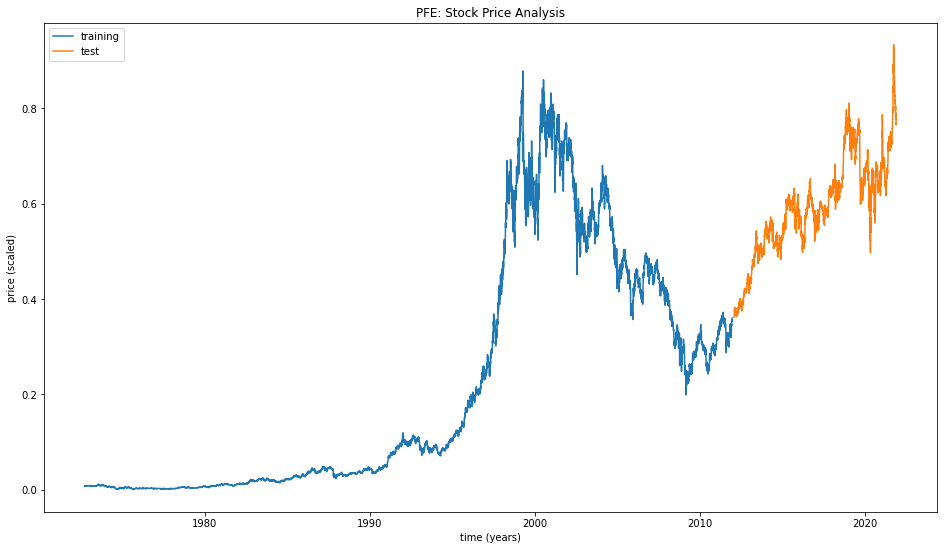

In [ ]:
plt.subplots(figsize=(16,9))
plt.plot(X_train_close_df,label="training")
plt.plot(X_test_close_df,label="test")
plt.title("PFE: Stock Price Analysis")
plt.xlabel("time (years)")
plt.ylabel("price (scaled)")
plt.legend();


#BUILDING THE MODEL

We are goint to be using 2 callbacks:     

**Model Checkpoint**: it saves the weights of the best (in terms of val_loss in our case) model.

**Early Stopping**: if the model does not improve (in terms of val_loss in our case) after n (PATIENCE) epochs, the training ends and keep the best model found so far.

In [ ]:
import tensorflow as tf
checkpoint_filepath = '/content/sample_data'
mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                           verbose=1,
                                                           monitor="val_loss",
                                                           save_weights_only=True)

PATIENCE = 10

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=1, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [ ]:
from keras.regularizers import l2
from sklearn.metrics import r2_score

tf.random.set_seed(42)

es = tf.keras.callbacks.EarlyStopping(patience=PATIENCE)


model = tf.keras.Sequential([
  tf.keras.layers.LSTM(128,return_sequences=False,
                      input_shape=(X_train.shape[1],X_train.shape[2]),
                      recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                       activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(n_per_out)
],name="model_1")



In [ ]:
%%time
model.compile(loss = "mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(1e-4)
              #metrics = [r2_score]
              )
model.summary()

tf.random.set_seed(42)
history = model.fit(
          X_train,y_train,
          epochs=100,
          validation_data=(X_test,y_test),
          batch_size=32,
          callbacks=[es,#create_model_checkpoint(model_name=model.name),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=30,
                                                                verbose=1)]
          )


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 70,922
Trainable params: 70,922
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
310/310 [==============================] - 38s 105ms/step - loss: 2.0552 - val_loss: 1.6401 - lr: 1.0000e-04
Epoch 2/100
310/310 [==============================] - 22s 71ms/step - loss: 1.4358 - val_loss: 1.2789 - lr: 1.0000e-04
Epoch 3/100
310/310 [==============================] - 22s 70ms/step - loss: 1

The reason why we are training the model twice is to speed up the process:
the callback ModelCheckPoint requires a lot of time since every time it sees an improvement with respect to the val_loss, it saves the model's weight; that's why I decided to add this callback after the first training when the major improvements have already been achieved.

In [ ]:
tf.random.set_seed(42)
history = model.fit(
          X_train,y_train,
          epochs=100,
          validation_data=(X_test,y_test),
          batch_size=32,
          callbacks=[es,create_model_checkpoint(model_name=model.name),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=30,
                                                                verbose=1)]
          )

Epoch 1/100
310/310 [==============================] - ETA: 0s - loss: 4.2556e-04
Epoch 00001: val_loss improved from inf to 0.00049, saving model to model_experiments/model_1
INFO:tensorflow:Assets written to: model_experiments/model_1/assets


310/310 [==============================] - 26s 82ms/step - loss: 4.2556e-04 - val_loss: 4.9030e-04 - lr: 1.0000e-04
Epoch 2/100
310/310 [==============================] - ETA: 0s - loss: 4.2877e-04
Epoch 00002: val_loss improved from 0.00049 to 0.00046, saving model to model_experiments/model_1
INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


310/310 [==============================] - 25s 81ms/step - loss: 4.2877e-04 - val_loss: 4.6436e-04 - lr: 1.0000e-04
Epoch 3/100
310/310 [==============================] - ETA: 0s - loss: 4.2246e-04
Epoch 00003: val_loss improved from 0.00046 to 0.00046, saving model to model_experiments/model_1
INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


310/310 [==============================] - 25s 81ms/step - loss: 4.2246e-04 - val_loss: 4.6162e-04 - lr: 1.0000e-04
Epoch 4/100
310/310 [==============================] - ETA: 0s - loss: 4.3163e-04
Epoch 00004: val_loss improved from 0.00046 to 0.00043, saving model to model_experiments/model_1
INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


310/310 [==============================] - 25s 82ms/step - loss: 4.3163e-04 - val_loss: 4.3076e-04 - lr: 1.0000e-04
Epoch 5/100
310/310 [==============================] - ETA: 0s - loss: 4.3803e-04
Epoch 00005: val_loss did not improve from 0.00043
310/310 [==============================] - 22s 72ms/step - loss: 4.3803e-04 - val_loss: 4.3720e-04 - lr: 1.0000e-04
Epoch 6/100
310/310 [==============================] - ETA: 0s - loss: 4.0528e-04
Epoch 00006: val_loss did not improve from 0.00043
310/310 [==============================] - 22s 72ms/step - loss: 4.0528e-04 - val_loss: 4.6750e-04 - lr: 1.0000e-04
Epoch 7/100
310/310 [==============================] - ETA: 0s - loss: 4.1656e-04
Epoch 00007: val_loss did not improve from 0.00043
310/310 [==============================] - 22s 72ms/step - loss: 4.1656e-04 - val_loss: 4.6697e-04 - lr: 1.0000e-04
Epoch 8/100
310/310 [==============================] - ETA: 0s - loss: 4.1839e-04
Epoch 00008: val_loss did not improve from 0.00043
310/

**The model is correctly learning since both the losses, training and validation, are decreasing for each epoch.**

I defined a function for evaluating the model with different regression metrics:

mae: Mean Absolute Value. 

$MAE=\frac{1}{n}\sum_{i=0}^n {|(y_i-\hat{y_i})|}$

mse: Mean Squared Error

$MSE=\frac{1}{n}\sum_{i=0}^n {(y_i-\hat{y_i})^2}$


rmse: Root Mean Squared Error

$RMSE = \sqrt{MSE}$


mape: Mean Absolute Percentage Error


$MAPE = \frac{100}{n}\sum_{i=0}^n |\frac{(y_i-\hat{y_i})}{y_i)}|$


${R^2}$(R2) = Coefficient of Determination

${R^2} =  1 - \frac{\sum_{i=0}^n (y_i-\hat{y_i})^2 }{\sum_{i=0}^n(y_i-\bar{y})^2} $  

where ${y_i}$ is the i-th actual value, $\hat{y_i}$ is the i-th predicted value and $\bar{y_i}$ the average value of the actual prices.



In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  R2 = r2_score(y_true,y_pred)
  R2 = np.float32(R2)

  
  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    #R2 = np.mean(r2_score)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "R2": R2
          }

def plot_history(history):
  plt.figure(figsize=(16,7))
  plt.plot(history.history['loss'],label="Training loss")
  plt.plot(history.history["val_loss"],label="Validation loss")
  plt.legend();     


In [ ]:
#Evaluation of the last model
model.evaluate(X_test,y_test)

78/78 [==============================] - 1s 7ms/step - loss: 4.8685e-04


0.0004868526302743703

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model = tf.keras.models.load_model("model_experiments/model_1")
model.evaluate(X_test,y_test)

78/78 [==============================] - 1s 7ms/step - loss: 4.3076e-04


0.00043075703433714807

#RESULTS

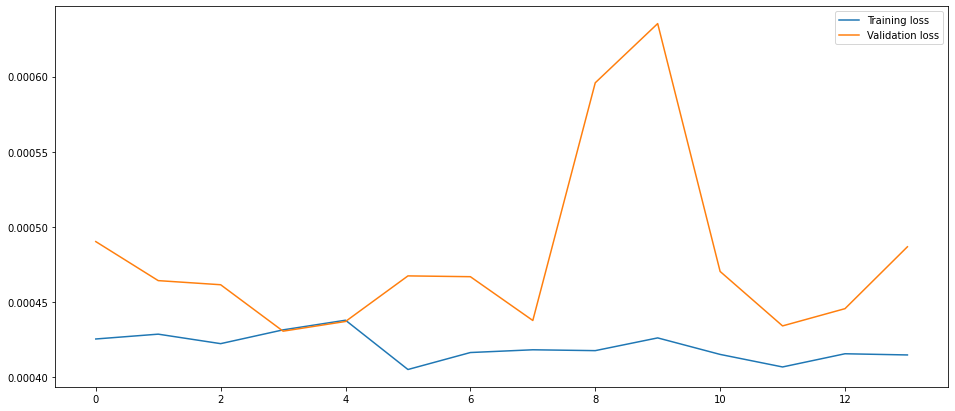

In [ ]:
plot_history(history=history)

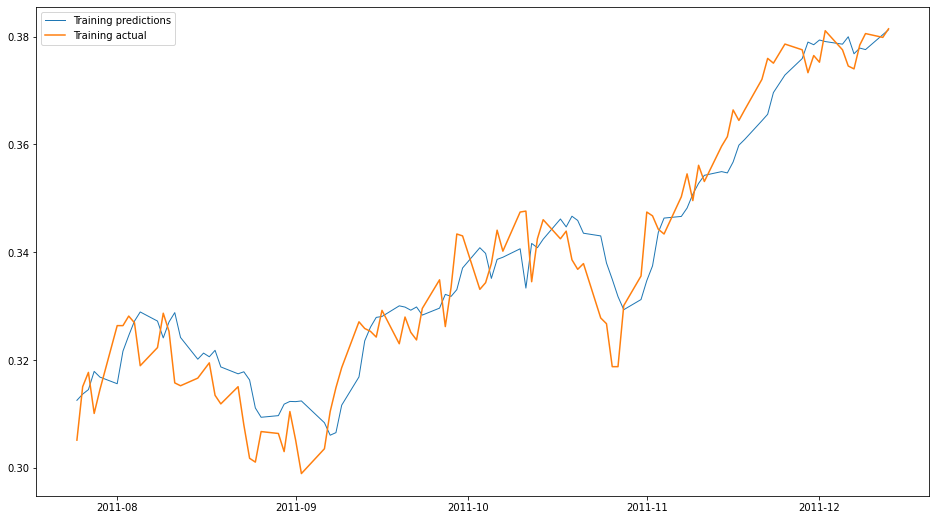

In [ ]:
y_preds_train = model.predict(X_train)
y_preds_train[:,0]
y_preds_train = pd.DataFrame(y_preds_train[:,0],columns=["yhat_train"])
y_preds_train.set_index(train_dates,inplace=True)

y_train = pd.DataFrame(y_train[:,0],columns=["y"])
y_train.set_index(train_dates,inplace=True)

plt.subplots(figsize=(16,9))
plt.plot(y_preds_train[-100:],label="Training predictions",linewidth=1)
plt.plot(y_train[-100:],label = "Training actual")
plt.legend()

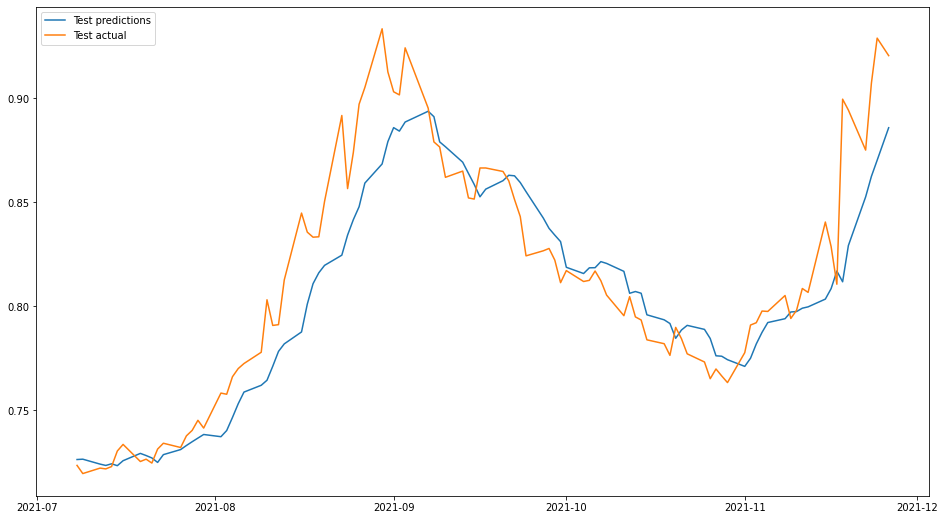

In [ ]:
y_preds_test = model.predict(X_test)
y_preds_test[:,0]
y_preds_test = pd.DataFrame(y_preds_test[:,0],columns=["yhat_test"])
y_preds_test.set_index(test_dates,inplace=True)

y_test = pd.DataFrame(y_test[:,0],columns=["y"])
y_test.set_index(test_dates,inplace=True)

plt.subplots(figsize=(16,9))
plt.plot(y_preds_test[-100:],label="Test predictions")
plt.plot(y_test[-100:],label = "Test actual")
plt.legend()

                    0
2021-11-27  41.908975
2021-11-28  41.907519
2021-11-29  41.941520
2021-11-30  41.887508
2021-12-01  41.995271
2021-12-02  41.909607
2021-12-03  41.929025
2021-12-04  41.840389
2021-12-05  41.815719
2021-12-06  41.811714


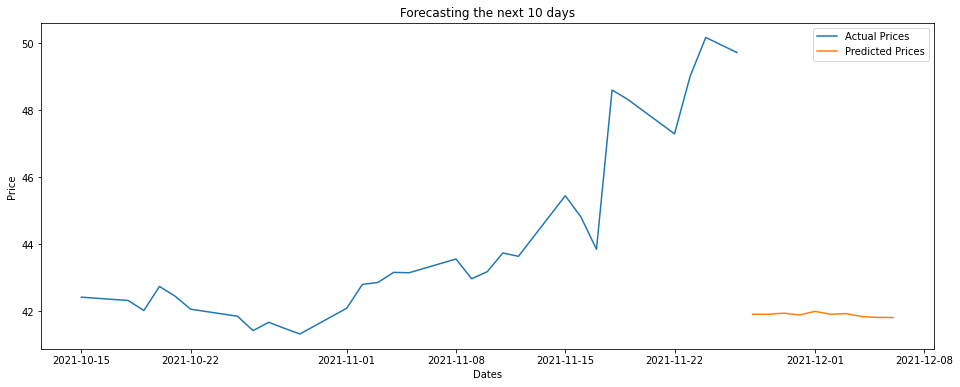

2021.11.27


In [ ]:
# Calculating last day
last_date = test_dates.tail(1)
first_future_day = last_date + np.timedelta64(1,'D')
first_future_day.reset_index(drop=True, inplace=True)
first_future_day = first_future_day.iloc[0].strftime('%Y.%m.%d')

# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(X_test_df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

#FORECASTING

# Creating a DF of predicted prices
#preds = pd.DataFrame(yhat, index=pd.date_range(start ="2021-06-11 12:30:00" , periods=len(yhat),freq="0h15min"))
preds = pd.DataFrame(yhat, index=pd.date_range(start =first_future_day , periods=len(yhat),freq="D"))

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 30


# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(y_test))
actual.set_index(test_dates,inplace=True)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual.tail(pers), label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("predictions.png")
plt.show()

print(first_future_day)

In [ ]:
evaluate_preds(y_test, y_preds_test)


{'R2': 0.98861486,
 'mae': 0.007610208,
 'mape': 1.2563239,
 'mse': 0.00012388066,
 'rmse': 0.007610208}

In [ ]:
true = true.set_index("timestamp")
true = true["close"]

In [ ]:
print(true)

timestamp
2021-11-12    49.730000
2021-11-15    49.650002
2021-11-16    49.599998
2021-11-17    50.869999
2021-11-18    51.410000
2021-11-19    50.799999
2021-11-22    51.200001
2021-11-23    51.080002
2021-11-24    50.889999
2021-11-26    54.000000
Name: close, dtype: float64


In [ ]:
preds1 = np.array(preds)
preds1

array([[41.90897522],
       [41.90751913],
       [41.94152004],
       [41.88750751],
       [41.99527073],
       [41.90960747],
       [41.92902516],
       [41.84038905],
       [41.81571859],
       [41.81171435]])

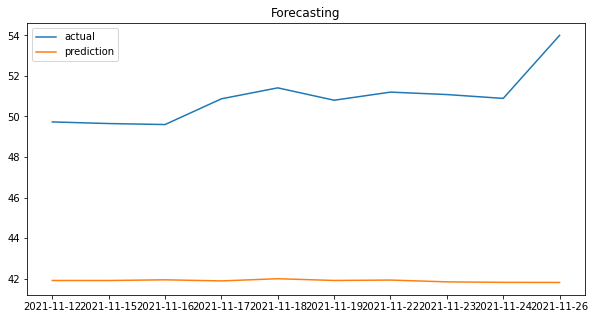

In [ ]:
plt.subplots(figsize=(10,5))
plt.title("Forecasting")
plt.plot(true,label = "actual")
plt.plot(preds1,label = "prediction")
plt.legend();

#CONCLUSION

It seems like that there is an offset between the actual prices and the predicted ones.
After doing some research and talking to a researcher in the field of Deep Learning I found out the lag problem!

Since time series models can never really predict what's going to happen in a stock market (including deep neural networks), they just end up predicting close to whatever was the previous day so it ends up looking like a shadow

That's normal error to expect when trying to predict in open systems (like a stock market).